## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/IMBD.zip

Archive:  /content/drive/MyDrive/IMBD.zip
   creating: IMBD/
  inflating: IMBD/imdb_dataset.csv   
  inflating: IMBD/unlabeled.csv      



We will import Relevant libraries which will be use for our porject.

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import math
import os
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import model_selection
from torch import nn
from torch import optim
from torchtext.legacy import data
from torch.utils.data import DataLoader
from wordcloud import WordCloud
import nltk
import re

%matplotlib inline
sns.set_style('whitegrid')

ModuleNotFoundError: ignored

In [ ]:
# for ignoring warnings
import warnings
warnings.filterwarnings("ignore")
import random
SEED = 1962
torch.manual_seed(SEED)

## Checking Device
Set the Device to GPU or CPU.

In [ ]:
# Check If the a GPU is available
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('GPU is not available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2060 with Max-Q Design


# Data loading and Pre_Processing

##### Read Dataset

In [ ]:
reviews = pd.read_csv("data/imdb_dataset.csv")

##### Dimensions of Data

In [ ]:
reviews.shape

(48000, 2)

##### Peak at the Data

In [ ]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
reviews.tail()

,review,sentiment
47995,"First of all, Blythe Danner doesn't look anywh...",negative
47996,I wouldn't be so quick to look at all the good...,negative
47997,Everything about this show is terrible. Its pr...,negative
47998,This movie just was not very funny. There's no...,negative
47999,"""The Yoke's on Me"" is undoubtedly the most con...",negative


##### Attributes in Data

In [ ]:
reviews.columns

Index(['review', 'sentiment'], dtype='object')

##### Describe the Data

In [ ]:
reviews.describe()

,review,sentiment
count,48000,48000
unique,47622,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,24000


It means there are some Duplicate Records in the data. 

Let's use groupby to use describe by label, this way we can begin to think about the features that separate Pos and Neg!

In [ ]:
reviews.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   24000  23724  You do realize that you've been watching the E...   
positive   24000  23898  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

### Text Pre-processing

##### Check Null Values

In [ ]:
reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

##### Check Duplicate Recode

In [ ]:
reviews.review.duplicated().sum()

378

In [ ]:
reviews.drop_duplicates(subset=['review'],keep='first',inplace=True) # drop duplicates and kepp one of them

##### Clean Text
Let's create a function that will process the string in the review column, then we can just use apply() in pandas do process all the text in the DataFrame.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akmalmasud96/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /home/akmalmasud96/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
stopwords = set(nltk.corpus.stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

In [ ]:
def preprocess(text, english_words):
    
    text = text.lower()
    html_tag = '<.*?>'
    text = re.sub(html_tag, '', text)
    # Removing Punctuation marks
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    rem_punc = tokenizer.tokenize(text)
    # Removing Stop Words
    rem_stop_words = [word for word in rem_punc if not word in stopwords]
    english_words = [word for word in rem_stop_words if word in english_words]
    sentence = ' '.join(english_words)
    
    return sentence

In [ ]:
test_example = 'I was not happy, then i visited Naran, such a beautiful place. Now I am in love with that place'

In [ ]:
clean_example = preprocess(test_example, english_words)

In [ ]:
clean_example

'happy beautiful place love place'

In [ ]:
reviews['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [ ]:
reviews['review'] = reviews['review'].apply(lambda x : preprocess(x, english_words))

In [ ]:
reviews['review'][3]

'basically family little boy jake zombie closet fighting time movie soap opera suddenly jake become kill zombie first going make film must decide thriller drama drama movie watchable like real life jake closet totally film see similar movie instead watched drama meaningless thriller well descent jake ignore'

#### Label Encoidng

In [ ]:
reviews['sentiment']= reviews['sentiment'].map( {'positive':1, 'negative': 0} ).astype(int)

### Exploratory Data Analysis

Let's make a new column to detect how long the text messages are:

In [ ]:
reviews['length'] = reviews['review'].str.len() #check Leanth of Each tweet
reviews.head()

,review,sentiment,length
0,one watching episode hooked right exactly firs...,1,757
1,wonderful little production technique unassumi...,1,458
2,thought wonderful way spend time hot summer we...,1,470
3,basically family little boy jake zombie closet...,0,307
4,petter love time money visually stunning film ...,1,620


In [ ]:
reviews.length.describe()

count    47622.000000
mean       607.156377
std        461.739841
min         17.000000
25%        323.000000
50%        451.000000
75%        739.000000
max       6378.000000
Name: length, dtype: float64

Maximum tweet leanth is 6378, which is very long and as we see mean is 607. We will remove long tweets. We will remove top 100 indexes with maximum length.

In [ ]:
reviews = reviews.sample(frac=1,random_state=SEED).reset_index(drop=True) #shuffle data frame

### Data Visualization

<AxesSubplot:xlabel='length', ylabel='Density'>

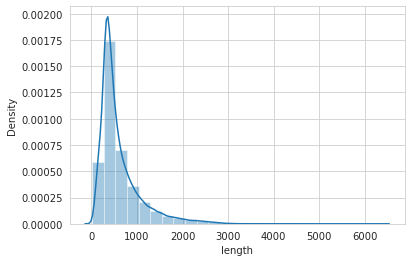

In [ ]:
sns.set_style('whitegrid')
sns.distplot(reviews['length'],bins=25)

Most of the reviews are between 0 to 1000 lengths. Now we will remove top 100 indexes with maximum length.

In [ ]:
np.sort(-reviews['length'])[0:100]

array([-6378, -6343, -5785, -5586, -4786, -4641, -4560, -4205, -4154,
       -4140, -4099, -4006, -3784, -3720, -3677, -3546, -3541, -3447,
       -3440, -3324, -3292, -3235, -3205, -3195, -3188, -3182, -3164,
       -3159, -3116, -3047, -3043, -3042, -3037, -3032, -3021, -3020,
       -3015, -3012, -3005, -2999, -2997, -2997, -2993, -2987, -2987,
       -2977, -2975, -2962, -2957, -2944, -2937, -2932, -2932, -2929,
       -2928, -2922, -2911, -2907, -2896, -2884, -2879, -2878, -2877,
       -2877, -2874, -2871, -2868, -2868, -2867, -2867, -2861, -2859,
       -2852, -2850, -2850, -2850, -2848, -2843, -2843, -2841, -2841,
       -2840, -2839, -2838, -2835, -2832, -2832, -2831, -2829, -2828,
       -2819, -2819, -2814, -2814, -2812, -2812, -2810, -2804, -2801,
       -2799])

In [ ]:
reviews.drop(reviews.index[np.argsort(-reviews['length'])[0:100]],axis=0,inplace=True)

In [ ]:
reviews.length.describe()

count    47522.000000
mean       601.662472
std        445.201237
min         17.000000
25%        322.000000
50%        450.000000
75%        736.000000
max       2797.000000
Name: length, dtype: float64

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

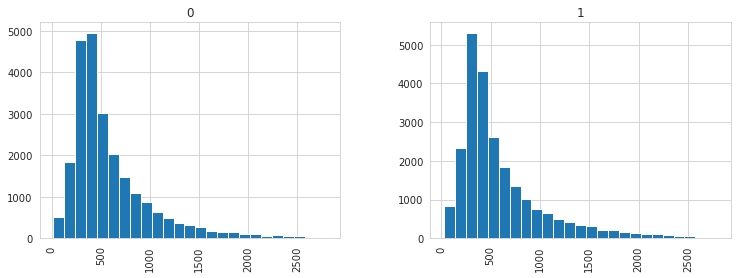

In [ ]:
reviews.hist(column='length', by='sentiment', bins=25,figsize=(12,4))

<AxesSubplot:xlabel='sentiment', ylabel='count'>

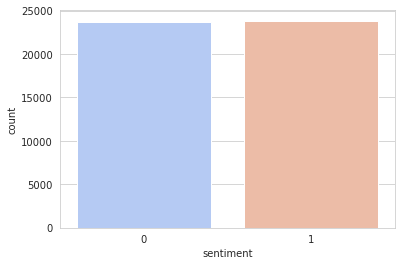

In [ ]:
sns.countplot(x='sentiment',data=reviews,palette='coolwarm')

#### Save the clean data

In [ ]:
reviews = reviews.sample(frac=1,random_state=SEED).reset_index(drop=True) #shuffle data frame
reviews.to_csv('data/clean.csv',index = False)

### TorchText
We will use the torchtext for loading the data and also do encoding with torchtext.

##### Load the dataset
We will load the dataset and create a vocab and resturn dataloader.

In [ ]:
def loadDataset(fix_length, batch_size,embedding_vector = '100'):
    
    # define the columns
    TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  init_token='<start>',
                  eos_token='<end>',
                 fix_length = fix_length)
    
    LABEL = data.LabelField(dtype = torch.long)
    
    # create tuples representing the columns
    fields = [
      ('review', TEXT),
      ('sentiment',LABEL)
    ]
    
    #### Create the Dataset
    dataset, test_dataset = data.TabularDataset.splits(
                                                       path='data',
                                                       train = 'clean.csv',
                                                       test = 'clean_unlabel.csv',
                                                       format = 'csv',
                                                       fields = fields,
                                                       skip_header = True,
                                                    )
    
    ## Split the data
    train_data, test_data = dataset.split(split_ratio=0.7, random_state = random.seed(SEED))
    train_data, valid_data = train_data.split(split_ratio=0.8, random_state = random.seed(SEED))
    print(f'Number of training examples: {len(train_data)}')
    print(f'Number of validation examples: {len(valid_data)}')
    print(f'Number of testing examples: {len(test_data)}')
    
    ### create Vocab
    MAX_VOCAB_SIZE = 30_000
    if embedding_vector == '300':
        
        TEXT.build_vocab(train_data, 
                         max_size = MAX_VOCAB_SIZE, 
                         vectors = "glove.6B.300d", 
                         unk_init = torch.Tensor.normal_)
        LABEL.build_vocab(train_data)
    else:
        TEXT.build_vocab(train_data, 
                         max_size = MAX_VOCAB_SIZE, 
                         vectors = "glove.6B.100d", 
                         unk_init = torch.Tensor.normal_)
        LABEL.build_vocab(train_data)
        
    ### create the Dataloader
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
                                                                                (train_data, valid_data, test_data), 
                                                                                batch_size = batch_size,
                                                                                sort_key = lambda x: x.review,
                                                                                sort_within_batch = True,
                                                                                device = device)
    
    return train_iterator, valid_iterator, test_iterator, TEXT, test_dataset

In [ ]:
embedding_vector = '300'
# create dataset loaders
train_loader, val_loader, test_loader, TEXT, test_dataset = loadDataset(fix_length, batch_size, embedding_vector)
# intilize the model
pad_idx = PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
input_dim = len(TEXT.vocab)

# define network
Net = Initialize_Network(type_of_rnn, input_dim,embedding_dim, hidden_dim_per_layer, output_dim, pad_idx, dropout)
print(Net)
### Pretrained Embedding
pretrained_embeddings = TEXT.vocab.vectors
Net.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
Net.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
Net.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)

In [ ]:
clean_example

'happy beautiful place love place'

In [ ]:
TEXT.tokenize(clean_example)

['happy', 'beautiful', 'place', 'love', 'place']

In [ ]:
TEXT.pad_token

'<pad>'

In [ ]:
temp = clean_example.split()
temp.insert(0,TEXT.init_token)
temp.append(TEXT.eos_token)

In [ ]:
temp

['<start>', 'happy', 'beautiful', 'place', 'love', 'place', '<end>']

In [ ]:
for pad in range(len(temp),200):
    temp.append(TEXT.pad_token) 

In [ ]:
encode = []
for word in temp:
    encode.append(TEXT.vocab.stoi.get(word))

In [ ]:
encode

[2, 465, 168, 149, 33, 149, 3]

In [ ]:
torch.transpose(torch.unsqueeze(torch.tensor(encode),0),0,1)

tensor([[  2],
        [465],
        [168],
        [149],
        [ 33],
        [149],
        [  3]])

In [ ]:
example = torch.transpose(torch.unsqueeze(torch.tensor(encode),0),0,1).type(torch.LongTensor)
example

tensor([[  2],
        [465],
        [168],
        [149],
        [ 33],
        [149],
        [  3]])

# Dat Pre processing(Wrong)

### Dataset Class

In [ ]:
class dataset(Dataset):
    def __init__(self, datapath):
        self.data = pd.read_csv(datapath)
        df1 = self.data.loc[self.data['sentiment'] == 'positive'].iloc[0:3000,:]
        df2 = self.data.loc[self.data['sentiment'] != 'positive'].iloc[0:3000,:]
        self.data = pd.concat([df1, df2], axis=0).reset_index(drop=True)
        #self.data = self.data.iloc[0:100,:]
        self.data['sentiment'] = np.where(self.data.sentiment == 'positive',1,0)
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer()
        

    def preprocess(self, text):
        lower = text.lower()
        # Removing Punctuation marks
        tokenizer = nltk.RegexpTokenizer(r"\w+")
        rem_punc = tokenizer.tokenize(lower)

        # Removing Stop Words
        stopwords = nltk.corpus.stopwords.words('english')
        rem_stop_words = [word for word in rem_punc if not word in stopwords]
        
        # Removing Non-English words 
        english_words = nltk.corpus.words.words()
        english_words = [word for word in rem_stop_words if word in english_words] 

        # Lemmatization
        lemmatizer = nltk.stem.WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in english_words]

        # Insert Start End tokens
        lemmatized_words.insert(0,'<start>')
        lemmatized_words.append('<end>')
        sentence = ' '.join(lemmatized_words)
    
        return sentence

    def encode_text(self, text):
        # Tokenization
        self.tokenizer.fit_on_texts(text)

        # Converting to sequences
        sequences = self.tokenizer.texts_to_sequences(text)
    
        # Padding Zeros
        max_len = 150

        self.tokenizer.word_index['<pad>'] = 0
        self.tokenizer.index_word[0] = '<pad>'
        padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
            sequences, maxlen=max_len, padding='post', truncating='post'
        )

        
        return padded_sequences
    
    def save_tokenizer(self):
        with open('tokenizer.pickle', 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        if index == len(self) - 1:
            self.save_tokenizer()
        
        text = self.data.review[index]
        target = self.data.sentiment[index]
        

        text = [self.preprocess(text)]
        encodings = self.encode_text(text)


        return torch.tensor(encodings), torch.tensor(target) 

### Load dataset Function

In [ ]:
def LoadDataset(train_data_path, train_batch_size=512, 
                val_batch_size=512, Shuffle=True):
    
    # loading datasets
    train = dataset(train_data_path)
    # test_data = dataset(test_data_path)

    #dividing dataset
    size = len(train)
    train_data, val_data = torch.utils.data.random_split(train,
                                                        [math.ceil(size * 0.8),
                                                         math.ceil(size * 0.2)])

    #creating data loaders
    train_loader = DataLoader(train_data, batch_size=train_batch_size,
                              shuffle=Shuffle)
    val_loader = DataLoader(val_data, batch_size=val_batch_size, shuffle=Shuffle)

    
    #Return
    return train_loader, val_loader